In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [2]:
## Load dataset
data_path = "../../../Rings_2D"
OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
RADI = torch.from_numpy(np.load(data_path + '/radi.npy')).float()
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()

NUM_DATASETS, N, D = OB.shape
SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))
NUM_EPOCHS = 200
NUM_HIDDEN = 32
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()

PATH = 'ag-phase1'

In [3]:
from decoder import *
dec_x = Dec_x(2, NUM_HIDDEN, CUDA)
recon_sigma = torch.ones((BATCH_SIZE, N, D)) * 0.1
if CUDA:
    dec_x.cuda()
    recon_sigma = recon_sigma.cuda()
optimizer =  torch.optim.Adam(list(dec_x.parameters()), lr=LEARNING_RATE, betas=(0.9, 0.99))

In [4]:
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    LOSS = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = OB[batch_indices]
        state = STATE[batch_indices]
        mu = MU[batch_indices]
        angle = ANGLE[batch_indices]
        
        labels = state.argmax(-1).unsqueeze(-1).repeat(1, 1, D)
        mu_copy = torch.gather(mu, 1, labels)
        ob_embedding = torch.cat((ob, mu_copy, angle), -1)

        ob_embedding = shuffler(ob_embedding)
        if CUDA:
            ob_embedding =ob_embedding.cuda()
        ob = ob_embedding[:, :, :2]
        mu = ob_embedding[:, :, 2:-1]
        angle = ob_embedding[:, :, -1].unsqueeze(-1)
        p = dec_x(ob, state, mu, angle, recon_sigma)
        loss =  - p['likelihood'].log_prob.sum()
        ## gradient step
        loss.backward()
        optimizer.step()  
        LOSS += loss
    time_end = time.time()
    print('epoch=%d, loss=%.4f (%ds)' % (epoch, LOSS / NUM_BATCHES, time_end - time_start))

epoch=0, loss=2172223.7500 (3s)
epoch=1, loss=196669.4062 (3s)
epoch=2, loss=6136.1475 (2s)
epoch=3, loss=-3544.1025 (3s)
epoch=4, loss=-6364.5698 (3s)
epoch=5, loss=-7649.7715 (3s)
epoch=6, loss=-8493.9443 (3s)
epoch=7, loss=-9031.7510 (2s)
epoch=8, loss=-9340.8506 (3s)
epoch=9, loss=-9524.2393 (3s)
epoch=10, loss=-9661.9521 (2s)
epoch=11, loss=-9770.6953 (3s)
epoch=12, loss=-9856.0225 (3s)
epoch=13, loss=-9926.8896 (3s)
epoch=14, loss=-9994.5723 (3s)
epoch=15, loss=-10024.5156 (3s)
epoch=16, loss=-10076.8262 (3s)
epoch=17, loss=-10103.0742 (3s)
epoch=18, loss=-10139.7295 (3s)
epoch=19, loss=-10162.4307 (3s)
epoch=20, loss=-10192.0566 (3s)
epoch=21, loss=-10210.1289 (3s)
epoch=22, loss=-10233.5879 (3s)
epoch=23, loss=-10234.7676 (3s)
epoch=24, loss=-10256.4199 (3s)


KeyboardInterrupt: 

In [7]:
torch.save(dec_x.state_dict(), '../results/dec_x-pretrained')

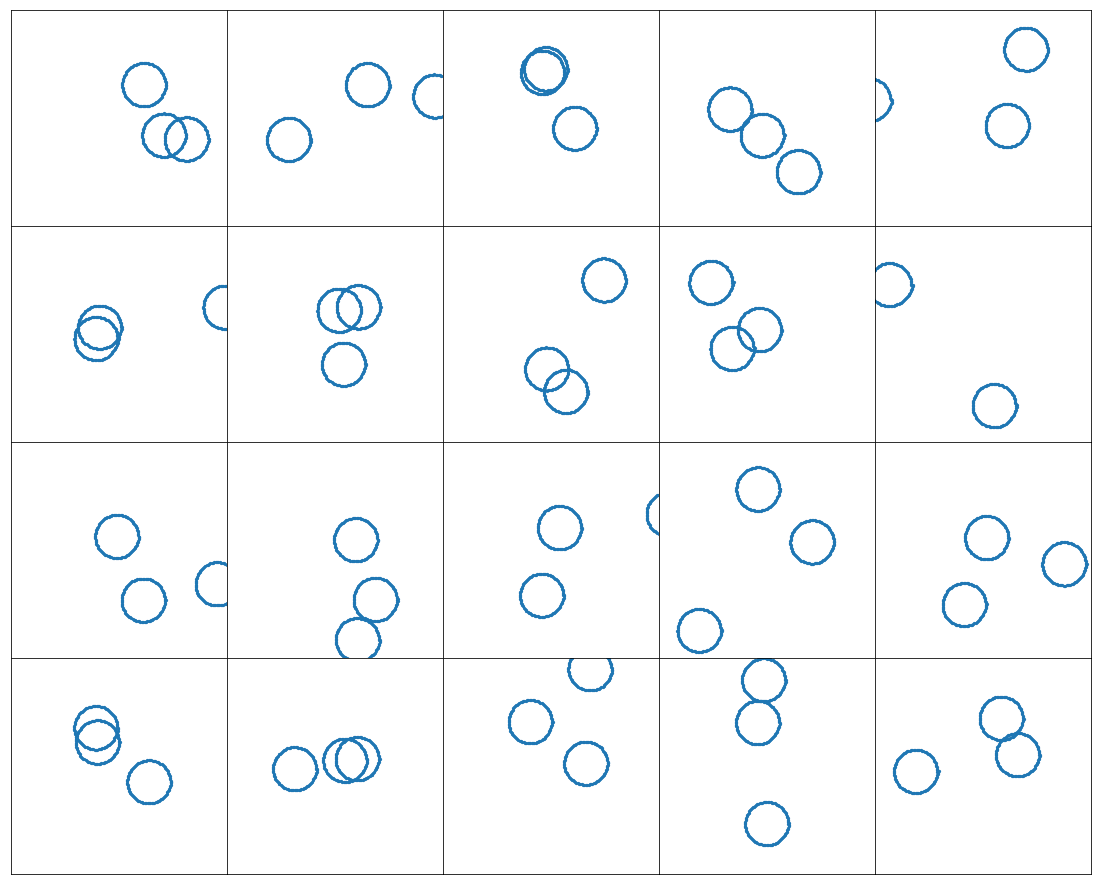

In [6]:
def plot_recon(recon, path, page_width, bound):
    B, N, D = recon.shape
    gs = gridspec.GridSpec(int(B / 5), 5)
    gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)
    fig = plt.figure(figsize=(page_width,page_width*4/5))
    for b in range(B):
        ax = fig.add_subplot(gs[int(b / 5), int(b % 5)])
        ax.scatter(recon[b, :, 0], recon[b, :, 1], s=5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim(-bound, bound)
        ax.set_xlim(-bound, bound)
    
indices = torch.randperm(NUM_DATASETS)
for step in range(NUM_BATCHES):
    optimizer.zero_grad()
    batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
    ob = OB[batch_indices]
    state = STATE[batch_indices]
    mu = MU[batch_indices]
    angle = ANGLE[batch_indices]

    labels = state.argmax(-1).unsqueeze(-1).repeat(1, 1, D)
    mu_copy = torch.gather(mu, 1, labels)
    ob_state_embedding = torch.cat((ob, state, mu_copy, angle), -1)

    ob_state_embedding = shuffler(ob_state_embedding)
    if CUDA:
        ob_state_embedding =ob_state_embedding.cuda()
    ob = ob_state_embedding[:, :, :2]
    state = ob_state_embedding[:, :, 2:5]
    mu = ob_state_embedding[:, :, 5:-1]
    angle = ob_state_embedding[:, :, -1].unsqueeze(-1)
    p = dec_x(ob, state, mu, angle, recon_sigma)
    break
recon_mu = p['likelihood'].dist.loc.cpu().data.numpy()
plot_recon(recon_mu, PATH, 15, 10)